## Using Data Science to Predict Fires in the Algerian Forest from Weather Characteristics
### Introduction
A forest fire is unplanned and uncontrollable and can occur by lightning or human carelessness in forests, grasslands or shrubbery (Government of Canada, 2020). The vast majority of forest fires are human-caused, however dry climate, hot temperatures, lightning, and volcanic eruption can also lead to their occurrence (National Park Service, 2018). The past decade of climate change has only exacerbated the amount of forest fires, leading to more frequent and extreme occurences.
 
Wildfire agencies use many variables to indicate an imminent wildfire and the evolution of machine learning has provided us the ability to predict future events by analyzing these variables. Thus, we pose the predictive question: do certain variables allow us to determine if a forest fire has or will occur and if so, how accurate will they be? 
 
To support our hypothesis, we used a dataset on Algerian Forest Fires from UCI (Faroudja & Izeboudjen, 2020). The dataset contains a culmination of forest fire observations and data in two regions of Algeria: the Bejaia region and the Sidi Bel-Abbes region. The timeline of this dataset is from June 2012 to September 2012. In this project, we focused on whether certain weather characteristics could predict forest fires in these regions using the K-NN Classification algorithm and later, we evaluated the accuracy of the model.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(GGally)
library(cowplot)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.10     ✔ rsample      0.1.1 
✔ dials        0.0.10     ✔ tune         0.1.6 
✔ infer        1.0.0      ✔ workflows    0.2.4 
✔ modeldata    0.1.1      ✔ workflowsets 0.1.0 
✔ parsnip      0.1.7      ✔ yardstick    0.0.9 
✔ recipes      0.1.17     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks

## Methods

#### Reading Data into R

The Algerian Forest Fires Dataset was read in through the `read_csv` function. 14 null values were found in the raw dataset and dropped. Since K-NN Classification requires numerical variables to predict an outcome, we converted all variables to numerical values and set the variable `Classes` as a factor to predict whether fires occur (`fire`) or otherwise (`not fire`). Our cleaned data is shown in Table 1 below.

In [2]:
check_na_values<-read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv', skip=1)
summary(is.na(check_na_values))

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 246 Columns: 14

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): day, month, year, Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, B...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



    day            month            year         Temperature    
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:246       FALSE:245       FALSE:245       FALSE:245      
                 TRUE :1         TRUE :1         TRUE :1        
     RH              Ws             Rain            FFMC        
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:245       FALSE:245       FALSE:245       FALSE:245      
 TRUE :1         TRUE :1         TRUE :1         TRUE :1        
    DMC              DC             ISI             BUI         
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:245       FALSE:245       FALSE:245       FALSE:245      
 TRUE :1         TRUE :1         TRUE :1         TRUE :1        
    FWI           Classes       
 Mode :logical   Mode :logical  
 FALSE:245       FALSE:244      
 TRUE :1         TRUE :2        

In [3]:
forest_fire<-read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv', skip=1)%>%
    select(-day, -month, -year)%>%
        filter(Classes!='Classes',
                Temperature!='NA',
                  RH!='NA',
                  Rain!='NA',
                    Ws!='NA',
                   FFMC!="NA",
                   DMC!="NA",
                   DC!="NA",
                   ISI!="NA",
                   BUI!="NA",
                   FWI!="NA") %>%
    mutate(Classes=as_factor(Classes),
        Temperature=as.numeric(Temperature),   
        RH=as.numeric(RH),
        Rain=as.numeric(Rain),
        Ws=as.numeric(Ws),
        FFMC=as.numeric(FFMC),
        DMC=as.numeric(DMC),
        DC=as.numeric(DC),
        ISI=as.numeric(ISI),
        BUI=as.numeric(BUI),
        FWI=as.numeric(FWI)) 

 head(forest_fire)

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 246 Columns: 14

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): day, month, year, Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, B...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Temperature RH Ws Rain FFMC DMC DC   ISI BUI FWI Classes 
1 29          57 18  0.0 65.7 3.4  7.6 1.3 3.4 0.5 not fire
2 29          61 13  1.3 64.4 4.1  7.6 1.0 3.9 0.4 not fire
3 26          82 22 13.1 47.1 2.5  7.1 0.3 2.7 0.1 not fire
4 25          89 13  2.5 28.6 1.3  6.9 0.0 1.7 0.0 not fire
5 27          77 16  0.0 64.8 3.0 14.2 1.2 3.9 0.5 not fire
6 31          67 14  0.0 82.6 5.8 22.2 3.1 7.0 2.5 fire

 <font color='grey'>Table 1: Initial Table for Algerian Forest Fires</font> 

#### Creating and Visualizing Training Data

To ensure our classification was accurate, we split the data into two sets: the training set and the testing set. We knew beforehand the `Classes` for the testing set, and using this information we were able to evaluate the accuracy of the classifier by predicting the training set with the testing set, thus having better confidence in predicting the likelihood of a forest fire should new data with similar variables be presented in the future.

The prop was set to 75% as the original dataset was assessed to be relatively small (249 entries). By propping to 75%, we were able to give the training set more samples from the data, which resulted in increased accuracy for our testing data. Our target variable would still be `Classes` since that was the variable we wished to predict.

In [4]:
forest_fire_split<- initial_split(forest_fire, prop= 0.75, strata= Classes)
forest_fire_train<-training(forest_fire_split)
forest_fire_test<-testing(forest_fire_split)

The correlation between variables was viewed with `ggpairs` in order to select for the variables to use for data analysis (See Figure 1).

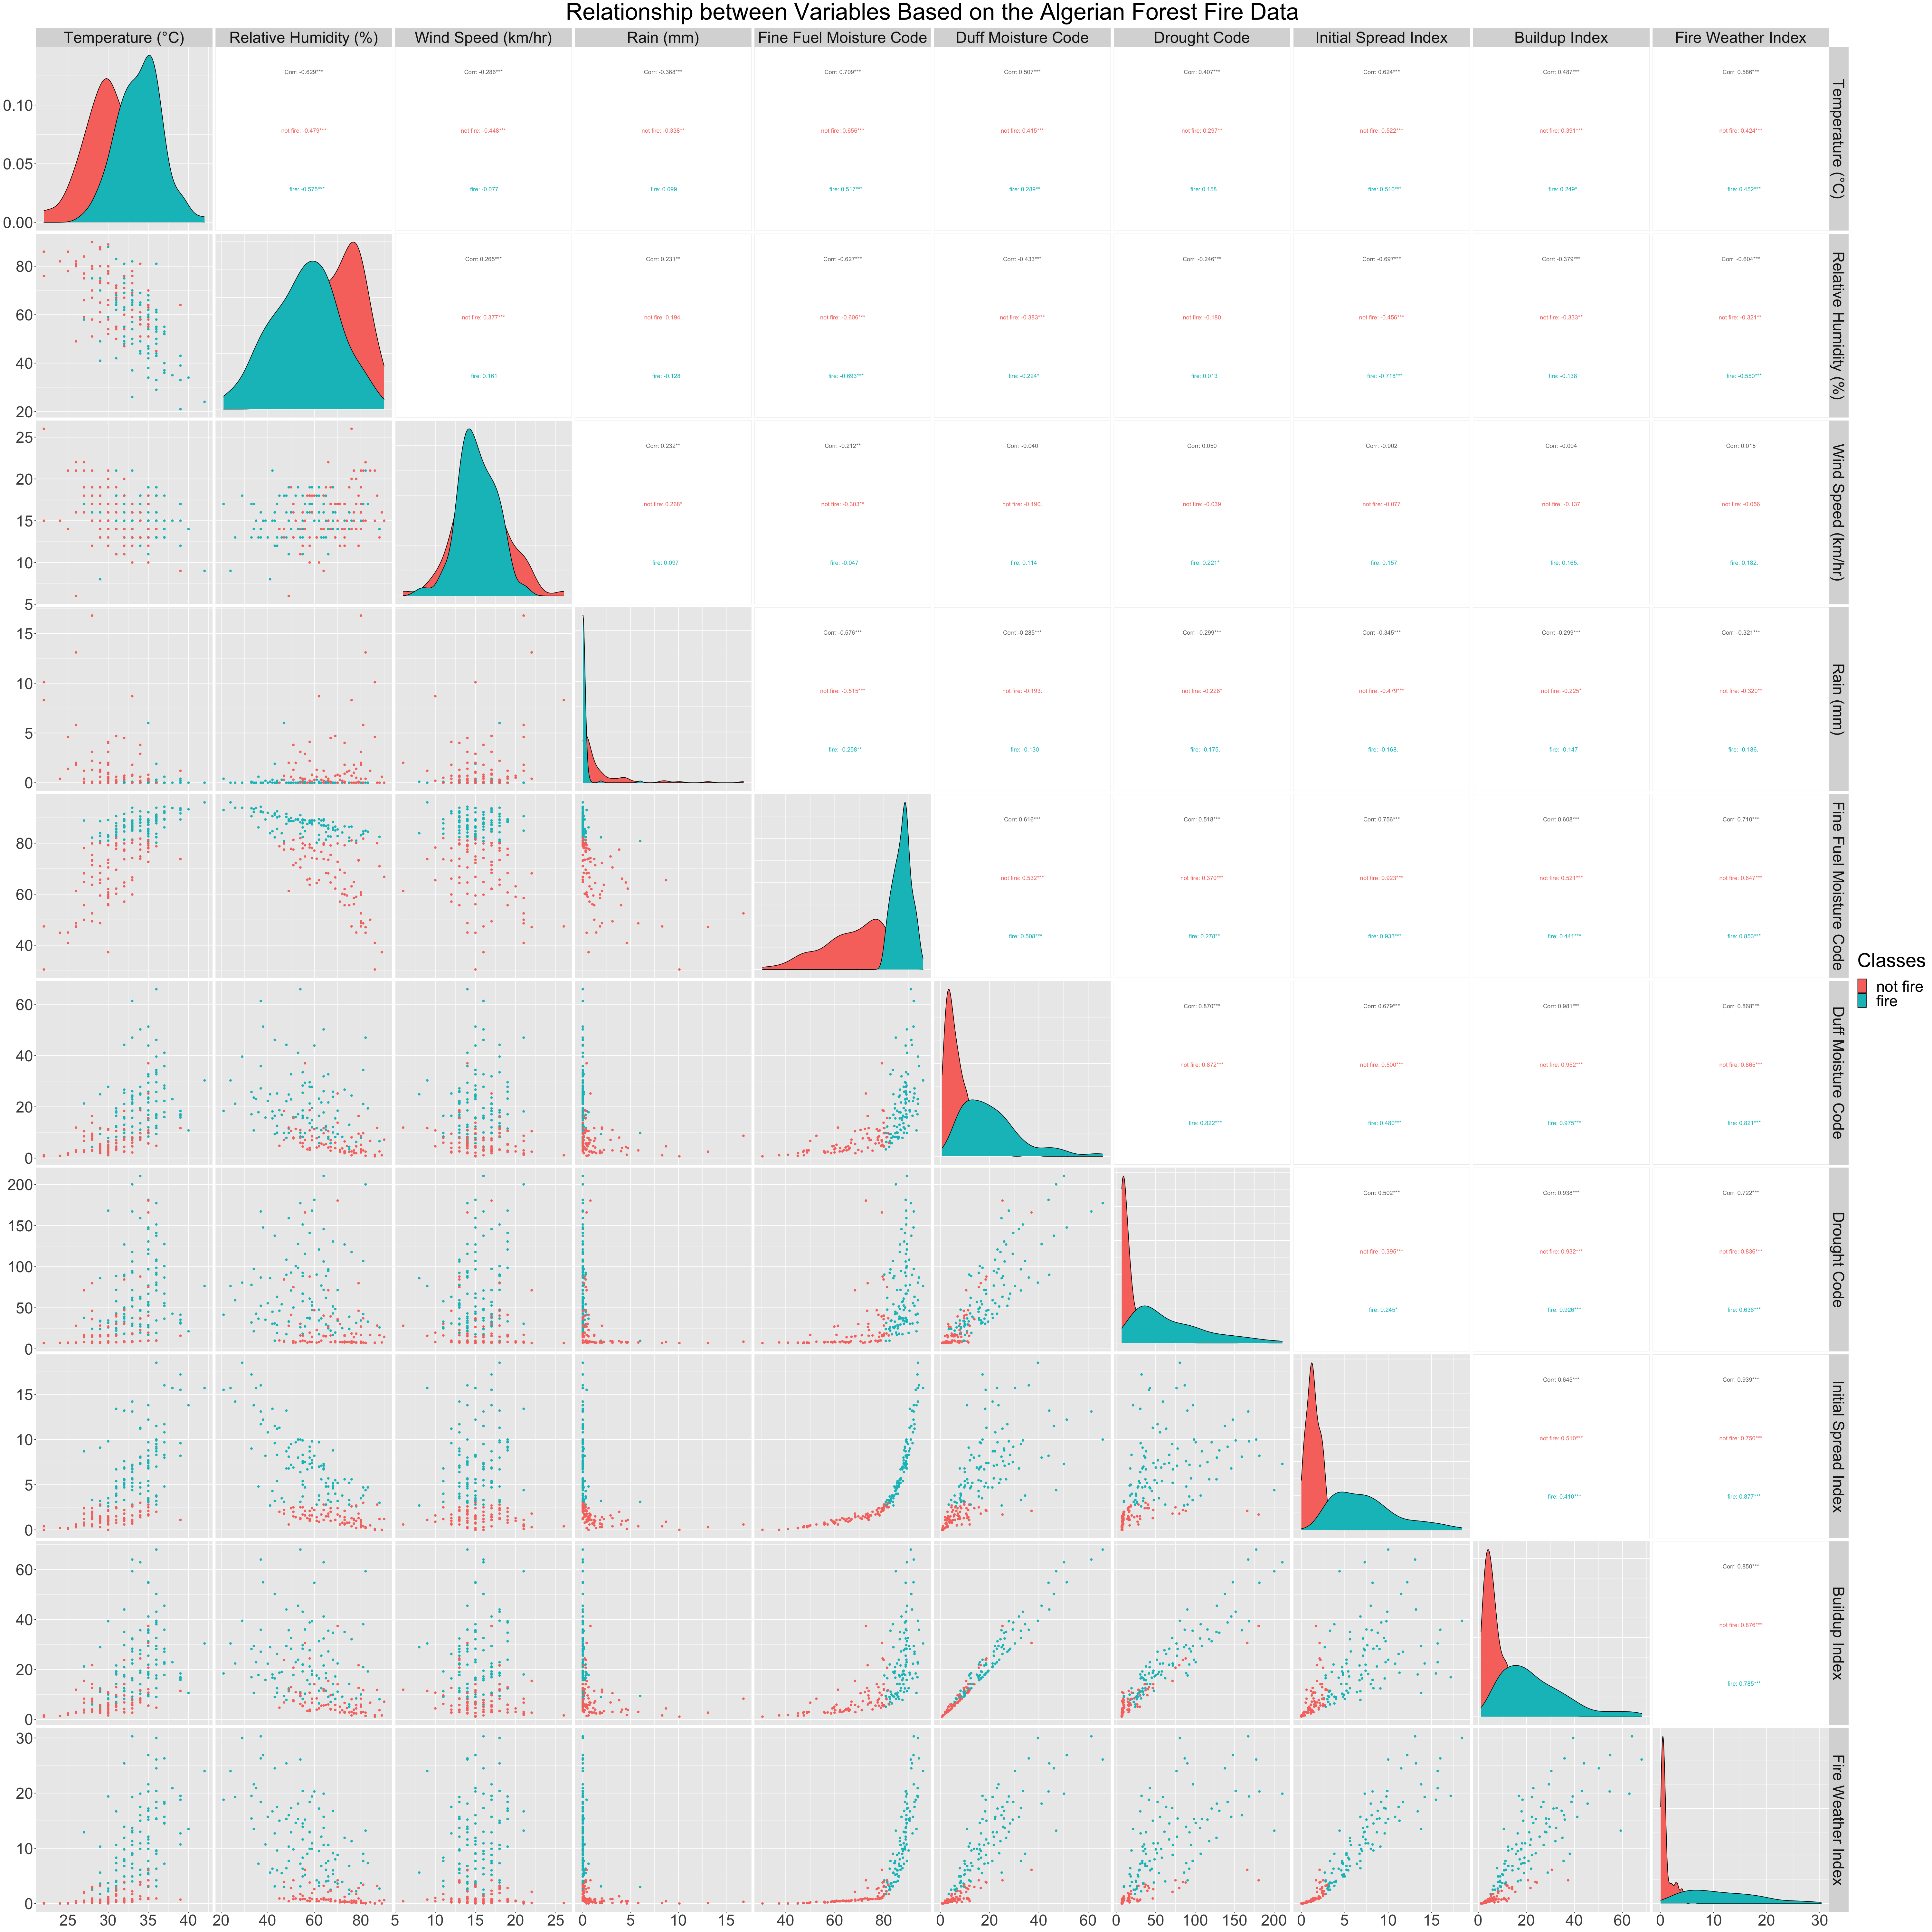

In [5]:
options(repr.plot.width=50, repr.plot.height=50)
forest_fire_graph <- forest_fire_train %>%
    ggpairs(columns =c('Temperature', 'RH','Ws','Rain','FFMC','DMC','DC','ISI','BUI','FWI'),
            columnLabels=c('Temperature (°C)', 'Relative Humidity (%)','Wind Speed (km/hr)', 'Rain (mm)','Fine Fuel Moisture Code','Duff Moisture Code',
                           'Drought Code','Initial Spread Index', 'Buildup Index','Fire Weather Index'),
            legend=1,
           aes(color=Classes))+
    ggtitle("Relationship between Variables Based on the Algerian Forest Fire Data") + 
    theme(text=element_text(size=36), plot.title = element_text(hjust = 0.5))


forest_fire_graph


 <font color='grey'>Figure 1: Plots based on the various variables in the Algerian Forest Fires Dataset</font> 

Based on the graph, we picked the variables with strong correlation and clustering as predictors for our K-NN model. The variables are as follows:
- Duff Moisture Code `DMC`  from 1.1 to 65.9  
- Drought Code `DC`  from 7 to 220.4  
- Initial Spread Index `ISI`  from 0 to 18.5  
- Buildup Index `BUI`  from 1.1 to 68  
- Fire Weather Index `FWI`  from 0 to 31.1


The data analysis was conducted in two main steps: 
1. Finding the $K$ value through cross validation 
2. Computing the accuracy of our prediction (the cross validation allowed us to choose the optimal $K$ value to utilize and yield accurate results in our classification model).

Next, we used the optimal $K$ value to predict the testing data with the training data through a classification workflow and then computed the accuracy of the prediction. Since this was an analysis using multiple variables, we chose to plot two graphs with two types of cross validations comparing accuracy against $K$. The following details of these two main steps are listed below.


#### Data Analysis: Choosing the K Value

The initial step in our data analysis was to find the most accurate $K$ value to use in our analysis. This was conducted in three steps:

First, we used the `nearest_neighbor` function and passed in the `tune()` function to tune our nearest neighbor model.

In [6]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Since K-NN classification predicts the classes of `fire` or `not_fire` by identifying nearby observations, it is imperative to ensure that variables with a larger value will not influence the other datapoints with a smaller value. Thus, we created a recipe and scaled the variables we chose in `forest_fire_train`. Note that this recipe is to be reused later in our data analysis after finding the $K$ value.

 

In [7]:
forest_fire_recipe <- recipe(Classes ~ DMC + DC + ISI + BUI + FWI, data = forest_fire_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
forest_fire_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we conducted both a 5-fold and 10-fold cross validation to divide the training data into 5 and 10 folds respectively (see Table 2 and Table 3). Each fold in the total number of folds will be given the opportunity to be a validation set. This is to prevent parts of the training data from being underrepresented which could result in selection bias.


In [8]:
forest_fire_vfold_5 <- vfold_cv(forest_fire_train, v = 5, strata = Classes)

forest_fire_results_5 <- workflow() %>%
  add_recipe(forest_fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = forest_fire_vfold_5, grid = 10) %>%
  collect_metrics()
head(forest_fire_results_5)

neighbors .metric  .estimator mean      n std_err     .config              
1 2         accuracy binary     0.9559888 5 0.013870806 Preprocessor1_Model01
2 2         roc_auc  binary     0.9853750 5 0.009793474 Preprocessor1_Model01
3 3         accuracy binary     0.9393222 5 0.015795868 Preprocessor1_Model02
4 3         roc_auc  binary     0.9923244 5 0.003755713 Preprocessor1_Model02
5 5         accuracy binary     0.9340669 5 0.021974125 Preprocessor1_Model03
6 5         roc_auc  binary     0.9893899 5 0.005489216 Preprocessor1_Model03

 <font color='grey'>Table 2: 5- Fold cross validation results</font> 

In [9]:
forest_fire_vfold_10 <- vfold_cv(forest_fire_train, v = 10, strata = Classes)

forest_fire_results_10 <- workflow() %>%
  add_recipe(forest_fire_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = forest_fire_vfold_10, grid = 10) %>%
  collect_metrics()


head(forest_fire_results_10)

neighbors .metric  .estimator mean      n  std_err     .config             
1 1         accuracy binary     0.9505504 10 0.012676719 Preprocessor1_Model1
2 1         roc_auc  binary     0.9526136 10 0.012176778 Preprocessor1_Model1
3 3         accuracy binary     0.9449948 10 0.014110337 Preprocessor1_Model2
4 3         roc_auc  binary     0.9963068 10 0.002117912 Preprocessor1_Model2
5 5         accuracy binary     0.9449948 10 0.011424294 Preprocessor1_Model3
6 5         roc_auc  binary     0.9937744 10 0.001826892 Preprocessor1_Model3

 <font color='grey'>Table 3: 10- Fold cross validation results</font> 

Finally, we selected the best value of the number of neighbours by filtering out the maximum mean in Table 2 and Table 3 (See Table 4 and 5). 

In [10]:
accuracies_5 <- forest_fire_results_5 %>%
    filter(.metric == "accuracy") %>%
    filter(mean == max(mean))
accuracies_5 #knn nearest neighbour for highest accuracy with a 5-fold cross-validation

neighbors .metric  .estimator mean      n std_err    .config              
1 2         accuracy binary     0.9559888 5 0.01387081 Preprocessor1_Model01

 <font color='grey'>Table 4: The nearest-neighbour for the 5-fold cross validaiton result based on the highest mean.</font> 

In [11]:
accuracies_10 <- forest_fire_results_10 %>%
    filter(.metric == "accuracy") %>%
    filter(mean == max(mean)) 
accuracies_10   #knn nearest neighbor for highest accuracy with a 10-fold cross-validation

neighbors .metric  .estimator mean      n  std_err    .config             
1 1         accuracy binary     0.9505504 10 0.01267672 Preprocessor1_Model1

 <font color='grey'>Table 5: The nearest-neighbour for the 10-fold cross validaiton result based on the highest mean.</font> 

Table 4 showed that when $C = 5$ (i.e. 5-fold cross-validation), the $K$ nearest neighbor with the highest accuracy is $K = 2$. In contrast, Table 5 showed that when $C = 10$ (i.e. 10-fold cross-validation), the $K$ nearest neighbours with the highest accuracy is $K = 1$.

In comparing Tables 4 and 5, we saw that $K= 2$ has a higher mean than $K = 1$ but a lower standard error than $K = 1$.  Nevertheless, we concluded that using a 5-fold cross validation with $K = 2$ was the best model for our classifier to predict the occurrences of fires in our testing data as the computational power needed for a 5-fold cross validation is less than that of a 10-fold cross validation (kernel took a long time to produce the output for the 10-fold code).  To confirm our analysis, we plotted an accuracy estimate versus $K$ graph whilst comparing the results of both 5 and 10-fold cross validations below (see Figure 2).



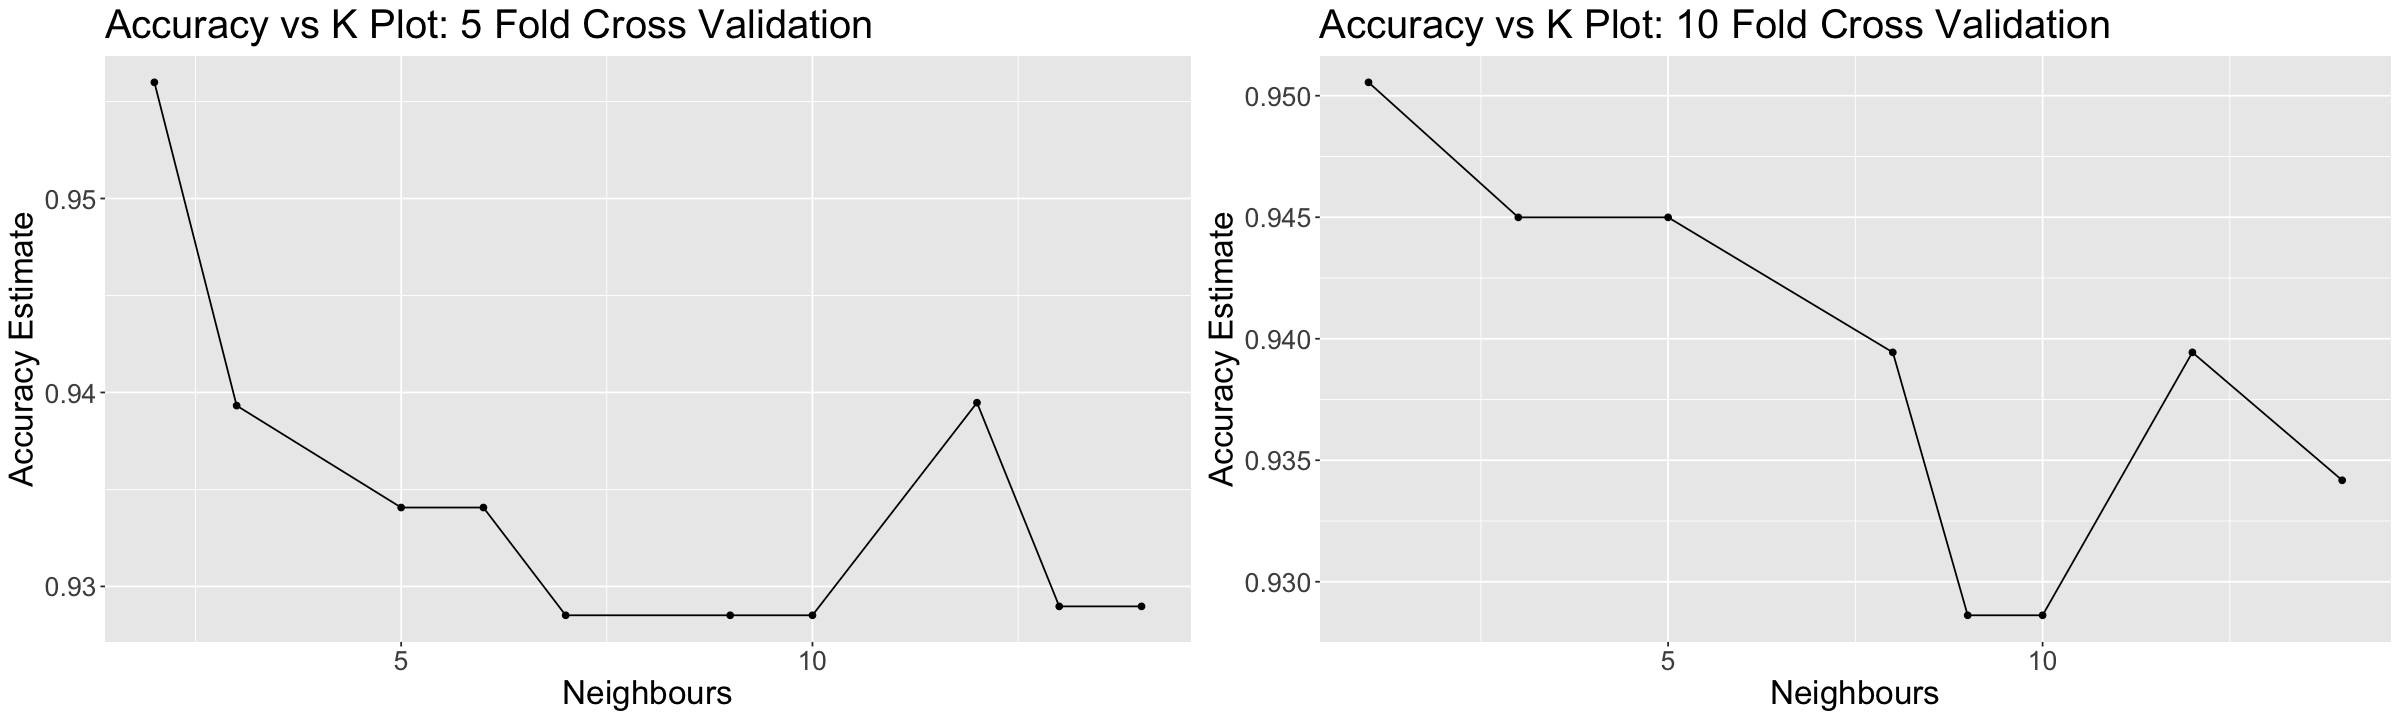

In [12]:
options(repr.plot.width = 20, repr.plot.height = 6) 

 accuracies_5_plot <- forest_fire_results_5 %>%
     filter(.metric == "accuracy") %>%
     ggplot(aes(x=neighbors,y=mean))+
     geom_point()+
     geom_line()+
     labs(x='Neighbours', y= 'Accuracy Estimate')+
     ggtitle('Accuracy vs K Plot: 5 Fold Cross Validation')+
    theme(text = element_text(size = 20))

 accuracies_10_plot <- forest_fire_results_10 %>%
     filter(.metric == "accuracy") %>%
     ggplot(aes(x=neighbors,y=mean))+
     geom_point()+
     geom_line()+
     labs(x='Neighbours', y= 'Accuracy Estimate')+
     ggtitle('Accuracy vs K Plot: 10 Fold Cross Validation')+
    theme(text = element_text(size = 20))



fina_k_plot<- plot_grid(accuracies_5_plot,accuracies_10_plot, ncol=2)
fina_k_plot

 <font color='grey'>Figure 2: Accuracy vs K Plot for 5 Fold Cross Validation compared with Accuracy vs K Graph for 10 Fold Cross validation</font> 

#### Data Analysis: Predicting the Testing Data

With the $K$ value chosen as $2$, we once again called the `nearest_neighbor` function to create our classification specification by using $K=2$ with our engine being `kknn` and our mode as `classification`.

In [13]:
forest_fire_spec<- nearest_neighbor(weight_func = 'rectangular', neighbors = 2) %>%
       set_engine('kknn') %>%
       set_mode('classification')

Next, we added the recipe and the model together in a workflow. We specified that the whole workflow would be applied to the training dataset using the `fit` function. This made a formula for us to prepare to predict the classifiers with the testing data.

In [14]:
forest_fire_fit<- workflow() %>%
          add_recipe(forest_fire_recipe) %>%
          add_model(forest_fire_spec) %>%
          fit(data=forest_fire_train)

forest_fire_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05524862
Best kernel: rectangular
Best k: 2

### Results

We called our `forest_fire_test` data to predict against the formula that we created above. In order to observe the effectiveness of the prediction, we binded the columns of the predicted class with the actual classes found in the training data (See Table 6).

In [15]:
forest_fire_predictions <-predict(forest_fire_fit , forest_fire_test) %>%
       bind_cols(forest_fire_test)
head(forest_fire_predictions)

.pred_class Temperature RH Ws Rain FFMC DMC  DC   ISI BUI  FWI Classes 
1 not fire    25          89 13 2.5  28.6  1.3  6.9 0.0  1.7 0.0 not fire
2 fire        30          73 15 0.0  86.6 12.1 38.3 5.6 13.5 7.1 fire    
3 not fire    25          88 13 0.2  52.9  7.9 38.8 0.4 10.5 0.3 not fire
4 fire        31          65 14 0.0  84.5 12.5 54.3 4.0 15.8 5.6 fire    
5 fire        26          81 19 0.0  84.0 13.8 61.4 4.8 17.7 7.1 fire    
6 not fire    29          89 13 0.7  36.1  1.7  7.6 0.0  2.2 0.0 not fire

 <font color='grey'>Table 6: Values of the predicted Class binded with the Classes from the training data</font> 

To ensure a hollistic view of the effectiveness of the formula, we used the `metrics` function to retrieve the statistics on the quality of our formula. The accuracy on the test data was 98% (See Table 7). This concluded that the accuracy of our model was 98% effective.

In [16]:
forest_fire_metrics<- forest_fire_predictions %>%
         metrics(truth = Classes, estimate = .pred_class)  
head(forest_fire_metrics)

.metric  .estimator .estimate
1 accuracy binary     0.983871 
2 kap      binary     0.967334

 <font color='grey'>Table 7: Accuracy on the formula predicted on `forest_fire_test`</font> 

### Discussion:
In conclusion, by using a 5-fold cross validation along with 2 neighbours, we were able to achieve the highest accuracy coupled with the lowest standard error when computing on the training data. Consequently, when the formula was applied to our testing data,  it was determined from Table 7 that our classifier was 98.39% accurate in predicting whether or not a given observation was a forest fire. It was expected that these predictors would allow us to infer if a given observation was or was not a forest fire as the plot in Figure 1 show that these variables displayed a positive correlation as well as clustering with one another.

These findings could lead to increased knowledge and proactivity in stopping forest fires that may occur in areas with similar predictor values to regions that have experienced forest fires. With the increased pressures of climate change in the modern era, there is no doubt that future applications of this model could be utilized as a prophylactic countermeasure to reduce the chance of forest fires (Government of Canada, 2020). This will also allow wildfire agencies to study past trends based on the data given and provide the appropriate training and education to its first responders.

A limitation of this report was the inability to produce a graph to visualize the decision boundaries of our model. This was the consequence of choosing multiple variables to include in our K-NN model. Currently, technological limitations (i.e visualizing in 5-D space) and best practices for data visualization has restricted us to avoid multi-dimensional plots as human readability is prioritized when inferring data. Additionally, selecting fewer variables could have been an alternative but it may have resulted in decreased accuracy and thus alter the result as a whole. 

This report also poses a future question that can be expanded upon further. Further research should be conducted in determining if variables with low correlation and clustering should be included in the K-NN model. An emphasis on choosing predictors with the highest correlation and clustering may skew the results and consequently will affect accuracy model. This may be a future topic of interest as we have selected variables based on strong correlation and clustering and in doing so neglected weaker correlations. As such, we may have introduced some biases in our model. By taking into account variables of different strengths of correlation and clustering, we can modify and reduce the bias of our $K$ Model.


### References
Government of Canada. (2020). *Forest fires*. Retrieved from https://www.nrcan.gc.ca/our-natural-resources/forests-forestry/wildland-fires-insects-disturban/forest-fires/13143.


National Park Service. (2018). *Wildfire Causes and Evaluations*. Retrieved from https://www.nps.gov/articles/wildfire-causes-and-evaluation.htm#:~:text=Nearly%2085%20percent*%20of%20wildland,and%20intentional%20acts%20of%20arson.&amp;text=Lightning%20is%20one%20of%20the%20two%20natural%20causes%20of%20fires.

Faroudja, A., Izeboudjen, N. (2020). Predicting forest fire in Algeria using data mining techniques: Case study of the decision tree algorithm. *International Conference on Advanced Intelligent Systems for Sustainable Development, 363-370*. Retrieved from https://link.springer.com/chapter/10.1007/978-3-030-36674-2_37